In [ ]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

100% 328M/329M [00:03<00:00, 139MB/s]
100% 329M/329M [00:03<00:00, 112MB/s]


In [ ]:
from zipfile import ZipFile

dataset = '/content/plant-village.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('Training',
                                                    shuffle = True,
                                                    image_size = (256,256),
                                                    batch_size=32,
                                                    )

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

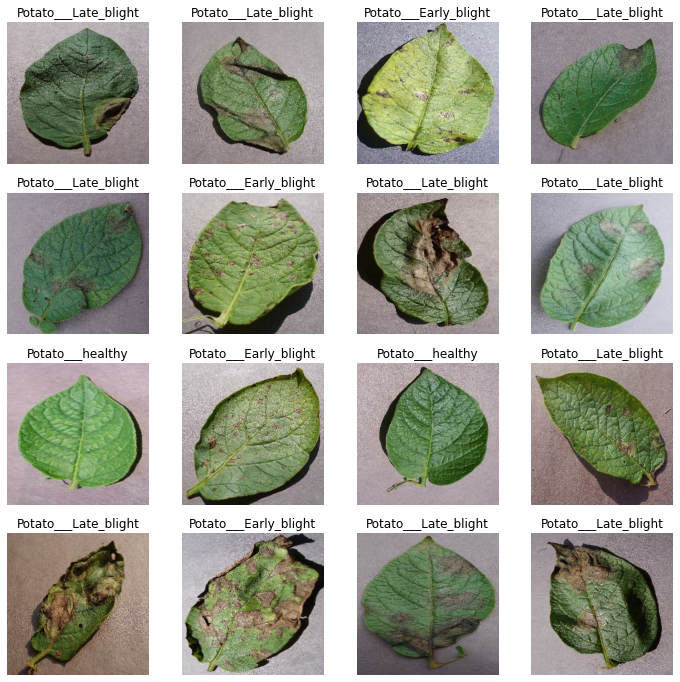

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(91)
len(train_ds)

68

In [ ]:
test_ds = dataset.skip(91)
len(test_ds)

0

In [ ]:
val_ds = test_ds.skip(11)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(11)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.build(input_shape=(32,256,256,3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 29s 159ms/step - loss: 0.9004 - accuracy: 0.4838 - val_loss: 0.8194 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 7s 127ms/step - loss: 0.6664 - accuracy: 0.7008 - val_loss: 0.4541 - val_accuracy: 0.7865
Epoch 3/50
54/54 [==============================] - 6s 119ms/step - loss: 0.3406 - accuracy: 0.8709 - val_loss: 0.2542 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 6s 117ms/step - loss: 0.2783 - accuracy: 0.8883 - val_loss: 0.2124 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 7s 130ms/step - loss: 0.2358 - accuracy: 0.8993 - val_loss: 0.1407 - val_accuracy: 0.9583
Epoch 6/50
54/54 [==============================] - 6s 116ms/step - loss: 0.2152 - accuracy: 0.9138 - val_loss: 0.1218 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 7s 129ms/step - loss: 0.2006 - accuracy: 0.9190 - val_loss: 0.1512 - val_accuracy: 0.9323
Epoch 8/50
54/54

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 27ms/step - loss: 0.0596 - accuracy: 0.9727


In [ ]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

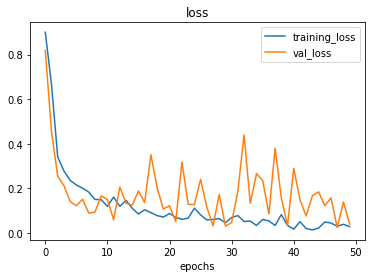

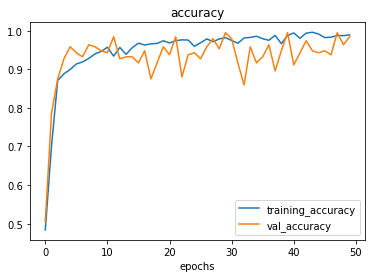

In [ ]:
plot_loss_curves(history)

In [ ]:
model_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model_1.build(input_shape=(32,256,256,3))

In [ ]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_1= model_1.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 6s 64ms/step - loss: 0.9097 - accuracy: 0.4913 - val_loss: 0.8560 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 3s 58ms/step - loss: 0.7647 - accuracy: 0.6429 - val_loss: 0.5277 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 3s 58ms/step - loss: 0.5308 - accuracy: 0.7697 - val_loss: 0.4590 - val_accuracy: 0.7604
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3795 - accuracy: 0.8356 - val_loss: 0.3915 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3260 - accuracy: 0.8779 - val_loss: 0.2080 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2454 - accuracy: 0.9034 - val_loss: 0.1109 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2046 - accuracy: 0.9178 - val_loss: 0.1614 - val_accuracy: 0.9479
Epoch 8/50
54

In [ ]:
scores = model_1.evaluate(test_ds)

8/8 [==============================] - 0s 28ms/step - loss: 0.0010 - accuracy: 1.0000


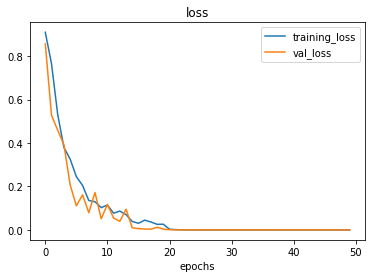

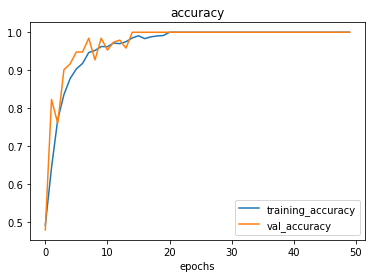

In [ ]:
plot_loss_curves(history_1)

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 120ms/step
predicted label: Potato___Early_blight


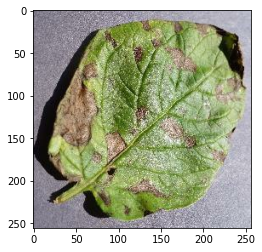

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_1.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


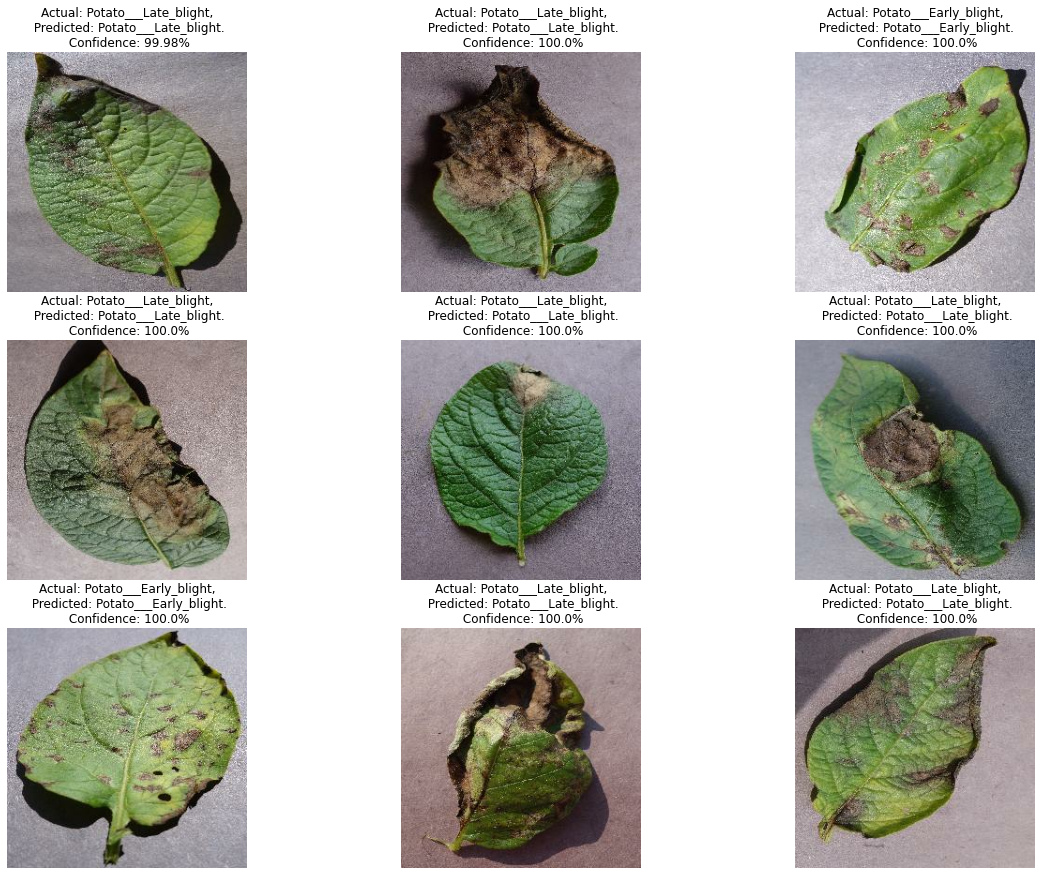

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model_1.save("Model_1.h5")